Author: Rene Pickhardt

This notebook investigates several things: 

* [Done] how often and far does the max_flow / min_cut diviate from the payment pairs existing incoming and outgoing liquidity 
* [X] Given a twosplit what is the best split ratio? 
* [X] How do various discussed splitting strategies behave?

In [19]:
import json
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
log = math.log2
from sympy import *


## Setup and data import

In [20]:
def import_channel_graph():
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.Graph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        cap = int(channel["satoshis"])
        G.add_edge(src,dest,cap=cap)
    return G

channel_graph = import_channel_graph()

In [21]:
def create_balanced_graph(channel_graph,p=0):
    """p is the probability that the channel is onsided. Thus the default p=0 creates a uniform distribution"""
    funded_network = nx.DiGraph()
    for src,dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        bal = None
        if random.random()>=p:
            bal = random.randint(0,cap)
        else:
            if random.random()>0.5:
                bal=0
            else:
                bal=cap
        funded_network.add_edge(src,dest,cap=cap,capacity=bal)
        funded_network.add_edge(dest,src,cap=cap,capacity=cap-bal)
    return funded_network
    
funded_network = create_balanced_graph(channel_graph,p=0.3)

In [22]:
nodes = set(funded_network.nodes)

## Experiment 1: Max Flow vs payment pairs local view: 

We assume a receiving node will not issue an invoice larger than the amount of satoshis it can theoretically receive. Similarly we assume a sending node will not try to pay an invoice if it does not have enough funds to do so. 

We want to see how ofter the maxflow is actually constrained by these two numbers given

* the actual channelGraph with real capacities
* a uniform distribution of balances (as measured before globally)

In [23]:
def compute_inbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[n][node]["capacity"]
    return res

def compute_outbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[node][n]["capacity"]
    return res


In [24]:
def create_samples(n=3600,p=0):
    res1 = []
    for i in range(n):
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        cut_value, partition = nx.minimum_cut(funded_network, src, dest)
        reachable, non_reachable = partition
        outbound = compute_outbound(funded_network,src)
        inbound = compute_inbound(funded_network, dest)
        print(src[:10],dest[:10], cut_value, outbound, inbound)
        lim = min(outbound,inbound)
        if lim==0: 
            res1.append(1.0)
        else:
            res1.append(cut_value/lim)
        if len(res1)%100 ==0:
            print(len(res1))
    return res1

In [9]:
def create_frequency_timeseries(res):
    # Attention we might have sampled the same payment pair twice!
    f=0
    frequencies = []
    for k,x in enumerate(reversed(res)):
        if x < 1.0:
            f+=1
        frequencies.append(f/(k+1))
    print(f/len(res), f, len(res))
    return frequencies
frequencies_uniform_model = create_frequency_timeseries(create_samples(3600,0))
frequencies_mixed_model = create_frequency_timeseries(create_samples(3600,0.3))

0216c9902e 036595db27 40000 40000 692263
025a707994 02429abf43 39999 39999 40187
02ed43c11f 027b333667 43278 59106 43278
030de14681 021db7e400 9294 9294 73134
02127bc2d5 03ca6c08d0 264634 2460510 264634
03dbe3fedd 03f9724780 24306 24306 1473511
032d4baebe 02e8980ad9 23280470 77195807 23746555
03eccf1c67 036347080d 364341 364341 841089
034e7907ac 027a768acf 261648 1112099 261648
026a0ccc1e 03b25a18c4 194690 1470590 194690
0278de991f 02355a8815 4829 225996 4829
0221444883 027f1cba8c 269502 269502 764219
0387a9f2ec 0307305c26 8789480 8789480 15003225
02ad96ab0b 034f664376 0 0 600000
03c1f88fb3 0237c16fa3 40000 40000 842390
020396bc00 0312ef6da6 344398 344398 591078
035874bc6d 03757e78cc 3578 93134 3578
03344ffade 03b2fce394 95474 202533 95474
031ff7a20f 03900174bd 41085 658626 41085
0325be312a 0374eb2306 136945 136945 39821940


KeyboardInterrupt: 

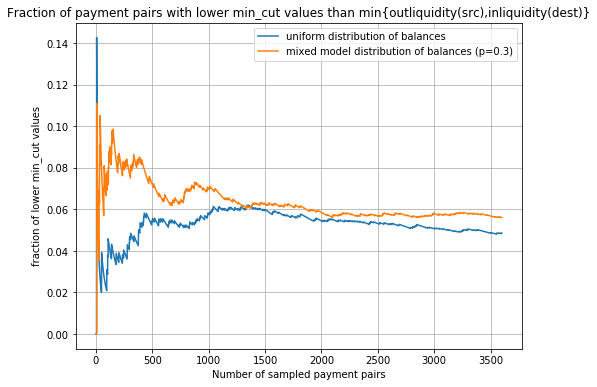

0.05611111111111111 0.04861111111111111


In [58]:
plt.figure(figsize=(8,6))
plt.title("Fraction of payment pairs with lower min_cut values than min{outliquidity(src),inliquidity(dest)}")
plt.plot(frequencies_uniform_model,label="uniform distribution of balances")
plt.plot(frequencies_mixed_model,label="mixed model distribution of balances (p=0.3)")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("fraction of lower min_cut values")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

print(f_mixed_model[-1], frequencys[-1])

In [60]:
# it would probably be better to use miletary standard 105D instead of creating a time series

## Experiment 2: optimal splitting ratio

We want to emperically estimate the expected number of attempts needed for various splitting ratios. This is to test the hypothesis that an equidistant splitting for multipart payments works best

In [25]:
def create_probability_graph(amt, channel_graph):
    prob_graph = nx.DiGraph()
    for src, dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        if cap <amt:
            continue
        success_probability = (cap - amt + 1) / (cap + 1)
        log_prob = log(success_probability)
        weight = -1*log_prob 
        #TODO: question could we ignore the amnt and use a weight that is based solely on capacities?
        prob_graph.add_edge(src,dest,weight=weight)
        prob_graph.add_edge(dest,src,weight=weight)
        
    return prob_graph

def update_graph(certain_edges, impossible_edges, prob_graph,debug=False):
    for src, dest in certain_edges:
        prob_graph[src][dest]["weight"]=0
    for src, dest in impossible_edges:
        #if debug is True:
        #print("removing ({},{})".format(src[:10],dest[:10]))
        if prob_graph.has_edge(src,dest):
            prob_graph.remove_edge(src,dest)


def next_hop(path):
    for i in range(1,len(path)):
        src = path[i-1]
        dest = path[i]
        yield (src,dest)

            
def test_path(path, amt, funded_network):
    certain_edges = []
    impossible_edges = []
    
    for src, dest in next_hop(path):
        if funded_network[src][dest]["capacity"] > amt:
            certain_edges.append((src, dest))
        else:
            impossible_edges.append((src,dest))
            break
    return certain_edges, impossible_edges

    
        
def print_path(path,funded_network):
    string = ""
    for src,dest in next_hop(path):
        string+=src[:10]
        #string+="--"+str(funded_network[src][dest]["capacity"])+"-->"
        string+="--"+str(funded_network[src][dest]["cap"])+"-->"
    string+=dest[:10]
    print(string)
    
def max_likelihood_pathfinding(src,dest,amt, channel_graph, funded_network):
    prob_graph=create_probability_graph(amt, channel_graph)
    
    impossible_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                      if funded_network[src][neighbor]["capacity"]<amt] 
    certain_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                   if funded_network[src][neighbor]["capacity"]>=amt]     
    update_graph(certain_edges,impossible_edges,prob_graph)
    
    attempts = 1
    while True:
        path = None
        try: 
            path = nx.shortest_path(prob_graph,src,dest)
        except:
            print("No Path between: {} and {}".format(src[:10],dest[:10]))
            return False, attempts
        certain_edges, impossible_edges = test_path(path, amt, funded_network)
        print_path(path,funded_network)
        if len(impossible_edges)>0:
            #print(certain_edges, impossible_edges)
            update_graph(certain_edges,impossible_edges,prob_graph)
            attempts+=1

        else:
            print("last path worked")
            break
    return True, attempts

In [150]:
def find_optimal_split_ratio(n):
    res = []
    for i in range(n):
        print("PAYMENT PAIR NUMBER: {}".format(i))
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        suc, att = max_likelihood_pathfinding(src, dest, 10000, channel_graph, funded_network)
        res.append((suc,att))
        print(res[-1],"\n")
    return res
res = find_optimal_split_ratio(100)

PAYMENT PAIR NUMBER: 0
02575614b8--8000000-->028a8e53d7--16777215-->034ea80f8b--3000000-->033c45158d
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 1
033c89e9e4--200000-->02ad6fb8d6--366172-->032679fec1--500000-->027d06253d
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 2
03fa7c2425--50000-->02e2670a2c--315836-->02ad6fb8d6--300000-->03634bda49--587163-->022ed00752
removing (02e2670a2c,02ad6fb8d6)
03fa7c2425--50000-->0206507b73--31337-->02ad6fb8d6--300000-->03634bda49--587163-->022ed00752
removing (0206507b73,02ad6fb8d6)
03fa7c2425--50000-->02e2670a2c--1000000-->021607cfce--1000000-->03634bda49--587163-->022ed00752
last path worked
(True, 3) 

PAYMENT PAIR NUMBER: 3
03d68d9358--100000-->03864ef025--1000000-->029c1f3113
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 4
039b0779bb--503035-->02ad6fb8d6--550000-->03d2a44997
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 5
023485c1f8--25000-->0242a4ae0c--1500000-->03e691f81f--450000-->0303e193d0
last path worked
(True, 1) 

PAYMEN

02a862abba--50000-->0217890e3a--500000-->029a874167--1312547-->023d70f2f7--70000-->03abadeb08
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 38
020dd87cbb--150000-->0297a77f4d--2000000-->03bb88ccc4--4000000-->023d70f2f7--100000-->024676acdb
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 39
removing (03da643f46,03e28223dc)
removing (03da643f46,02c0b38022)
removing (03da643f46,0237fefbe8)
removing (03da643f46,02462361f6)
03da643f46--405129-->02ad6fb8d6--342244-->031d244a60--250000-->024e0d88d5
removing (02ad6fb8d6,031d244a60)
03da643f46--405129-->02ad6fb8d6--2000000-->03bb88ccc4--2000000-->024e0d88d5
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 40
removing (03c492f46d,022c260f9a)
removing (03c492f46d,0331f80652)
removing (03c492f46d,03bec39890)
03c492f46d--323956-->0217890e3a--40000-->0203561593
removing (0217890e3a,0203561593)
No Path between: 03c492f46d and 0203561593
(False, 2) 

PAYMENT PAIR NUMBER: 41
removing (03f21fc2e8,02c91d6aa5)
03f21fc2e8--358517-->02ad6fb8d6--35000

removing (028533290b,021607cfce)
removing (028533290b,02a04446ca)
No Path between: 028533290b and 023e72b9c6
(False, 1) 

PAYMENT PAIR NUMBER: 77
removing (02eec95b8e,032679fec1)
02eec95b8e--25000-->0395033b25--8000000-->0242a4ae0c--20000-->025a663692
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 78
0355d39776--800000-->03864ef025--16777215-->028a8e53d7--4919424-->02bd850135
removing (03864ef025,028a8e53d7)
0355d39776--800000-->03864ef025--10000000-->0217890e3a--1000000-->02b6dabd43--1000000-->02bd850135
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 79
023fe0a6b1--40000-->024b0f1e45--350000-->02ad6fb8d6--1000000-->02bbebbd51
removing (02ad6fb8d6,02bbebbd51)
023fe0a6b1--40000-->024b0f1e45--2500000-->0309bd6a02--2500000-->02bbebbd51
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 80
030d475976--70000-->02315fe361--500000-->03d3cc1f07--2300000-->0297a77f4d--360000-->0352370879
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 81
036132fa7e--98515-->022755c3ff--16000000-->0331f80

removing (02362eb8e5,0217890e3a)
removing (02362eb8e5,0331f80652)
02362eb8e5--8626782-->0316787453--16777215-->03dab87ff8--1997701-->024ba3b889
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 118
03b38d5b58--34728-->03e5ea100e--349085-->02ad6fb8d6--1500000-->03dc8f04a9
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 119
removing (027578e823,02607c9c92)
removing (027578e823,033d607b60)
removing (027578e823,027fb5a315)
removing (027578e823,03cde60a63)
027578e823--31337-->02ad6fb8d6--300000-->033ac2f9f7--225148-->0221444883
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 120
0328ca8646--489408-->03757b8030--350000-->02ad6fb8d6--333048-->0297a77f4d--100000-->030f108ab6
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 121
03fa876953--95787-->03bb88ccc4--2000000-->02ad6fb8d6--108240-->03321fab5e
removing (02ad6fb8d6,03321fab5e)
03fa876953--95787-->03bb88ccc4--900000-->03d37fca06--9000000-->03321fab5e
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 122
0386ba5b70--70000-->02315fe361-

removing (036d4c098b,02c91d6aa5)
removing (036d4c098b,03d7c20452)
036d4c098b--836849-->03864ef025--10000000-->0217890e3a--265915-->02eef44bb2
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 157
0308c5e0c4--1578087-->02b0172bb3--15995810-->03864ef025--2250000-->02c87ddac0
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 158
removing (0371513dee,0338f87cb0)
removing (0371513dee,022c260f9a)
0371513dee--500000-->0242a4ae0c--250000-->029a874167--1068466-->0271024435
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 159
03f3eba975--20000-->020e8091a5--31337-->02ad6fb8d6--373643-->0316787453--100000-->033d3b07ae
removing (020e8091a5,02ad6fb8d6)
03f3eba975--20000-->020e8091a5--175000-->03c2d52cdc--100000-->0316787453--100000-->033d3b07ae
removing (0316787453,033d3b07ae)
No Path between: 03f3eba975 and 033d3b07ae
(False, 3) 

PAYMENT PAIR NUMBER: 160
03631102b0--300000-->03abf6f44c--1280633-->02a0bcc2b9
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 161
removing (036ddf3e57,03c8dfbf82)
No

removing (036d33fbd3,023d70f2f7)
No Path between: 036d33fbd3 and 025d780b5d
(False, 1) 

PAYMENT PAIR NUMBER: 181
removing (033d865621,026726a4b0)
removing (033d865621,03bb88ccc4)
removing (033d865621,03efccf2c3)
removing (033d865621,026ac9fcd6)
removing (033d865621,03d67f36c4)
removing (033d865621,03da1c27ca)
removing (033d865621,03e5ea100e)
removing (033d865621,024d238740)
removing (033d865621,024b801979)
removing (033d865621,021607cfce)
removing (033d865621,0314da85ec)
removing (033d865621,03aca01423)
removing (033d865621,035a95bdaf)
removing (033d865621,0261658504)
removing (033d865621,037e1439d8)
removing (033d865621,02b6dabd43)
removing (033d865621,029ef8ee0b)
removing (033d865621,03037dc08e)
removing (033d865621,03c990306d)
removing (033d865621,0378d8b9a4)
removing (033d865621,03ae5e2427)
removing (033d865621,02d6b78e7c)
removing (033d865621,02f6155b10)
removing (033d865621,024bd0783a)
removing (033d865621,0387cc9d41)
removing (033d865621,02f7fc17b4)
removing (033d865621,0309bd6

02c79d1677--100000-->0297a77f4d--333048-->02ad6fb8d6--330335-->02de11c748--353191-->02dda24009
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 215
removing (034f664376,03fce16553)
No Path between: 034f664376 and 0304421deb
(False, 1) 

PAYMENT PAIR NUMBER: 216
02ace7acad--100000-->0227230b7b--10000000-->032cc4541b--6000000-->02537e3176
removing (0227230b7b,032cc4541b)
02ace7acad--100000-->0227230b7b--500000-->02a04446ca--300000-->02537e3176
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 217
036aaa2780--47915-->02de60d194--71337-->02ad6fb8d6--350000-->024b0f1e45
removing (02de60d194,02ad6fb8d6)
036aaa2780--47915-->02de60d194--1000000-->021607cfce--1000000-->024b0f1e45
removing (02de60d194,021607cfce)
036aaa2780--47915-->02de60d194--1000000-->03abf6f44c--16777215-->03e28223dc--16756065-->024b0f1e45
removing (02de60d194,03abf6f44c)
036aaa2780--47915-->02de60d194--382258-->0217890e3a--354635-->02ad6fb8d6--350000-->024b0f1e45
last path worked
(True, 4) 

PAYMENT PAIR NUMBER: 218
0304cc

02eb9a95a0--1093819-->02004c625d--364748-->02ad6fb8d6--2000000-->0395033b25--2000000-->02fd17656f
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 254
removing (0288be11d1,030c3f19d7)
removing (0288be11d1,0231eccc65)
removing (0288be11d1,03c2b5e971)
removing (0288be11d1,03d0675858)
removing (0288be11d1,0298f6074a)
0288be11d1--20000000-->02529db69f--3000000-->0232c9cdca
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 255
027e1cc3e5--515386-->02004c625d--1072790-->02572c2e1b
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 256
02c42d4c69--31337-->02ad6fb8d6--300000-->03b1ba0b91
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 257
removing (0314cf6208,033d865621)
0314cf6208--170000-->0395033b25--16777215-->03864ef025--5000000-->0331feaa48
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 258
removing (0213355124,02c1ac5cee)
removing (0213355124,039faad98d)
removing (0213355124,0297a77f4d)
0213355124--250000-->03668e08fe--16777215-->02d4b43205
last path worked
(True, 1) 

PAYMENT PAIR

removing (024712c782,0331f80652)
No Path between: 024712c782 and 03732acfa9
(False, 1) 

PAYMENT PAIR NUMBER: 293
02fc41b20b--90000-->03baa70886--16770000-->03fce16553--355226-->035d61eb24
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 294
02d0243366--124566-->03434a39cd--10000000-->02ad6fb8d6--31337-->026db2cbf3--60000-->03e8300972
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 295
removing (024d6ba760,03bb88ccc4)
removing (024d6ba760,024a8228d7)
024d6ba760--989111-->0260fab633--100000000-->03864ef025--232389-->0359ef8e71
removing (0260fab633,03864ef025)
024d6ba760--1000000-->0395033b25--16777215-->03864ef025--232389-->0359ef8e71
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 296
03114576a6--100000-->0227230b7b--500000-->02ad6fb8d6--300000-->03634bda49--587163-->022ed00752
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 297
02675c7e67--71337-->02ad6fb8d6--31337-->029e2a4fae--20000-->039bc79ceb
removing (029e2a4fae,039bc79ceb)
No Path between: 02675c7e67 and 039bc79ceb
(Fals

(True, 1) 

PAYMENT PAIR NUMBER: 337
removing (0216df2c04,02ade55c81)
0216df2c04--125000-->037659a0ac--10000000-->02ad6fb8d6--301649-->034ea80f8b
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 338
removing (038199a41d,03864ef025)
removing (038199a41d,03634bda49)
038199a41d--232667-->0217890e3a--10000000-->03864ef025--40000000-->02816caed4
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 339
039ba6a295--61337-->02ad6fb8d6--354635-->0217890e3a--381843-->0361e26a49
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 340
02acae80ee--650000-->0242a4ae0c--1000000-->02b0172bb3--5000000-->02a0591e84--100000-->03cdffcbd7
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 341
03665b4dfe--2000000-->03bef00428--790000-->03864ef025--16777215-->0331f80652--500000-->0386ee3ccf
removing (0331f80652,0386ee3ccf)
No Path between: 03665b4dfe and 0386ee3ccf
(False, 2) 

PAYMENT PAIR NUMBER: 342
removing (0316787453,03abf6f44c)
removing (0316787453,03ec0c1e45)
removing (0316787453,0236d51519)
removing (031

(True, 1) 

PAYMENT PAIR NUMBER: 363
removing (036886ff20,0390b5d449)
removing (036886ff20,0364b672df)
036886ff20--421555-->03bb88ccc4--2000000-->03c2abfa93--250000-->0329172c01
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 364
removing (029679e5a0,02b56712f6)
029679e5a0--6000000-->03957c8011--16777215-->02c91d6aa5--20000-->0259a63bbf
removing (02c91d6aa5,0259a63bbf)
029679e5a0--6000000-->03957c8011--1296478-->031ce29116--20000-->0259a63bbf
removing (031ce29116,0259a63bbf)
No Path between: 029679e5a0 and 0259a63bbf
(False, 3) 

PAYMENT PAIR NUMBER: 365
0211946c51--9000000-->022c260f9a--16777215-->021607cfce
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 366
03b2a092a8--200000-->028a8e53d7--16777215-->03864ef025--1300000-->02d81ee7a2
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 367
034858e158--257000-->0331f80652--4990000-->02262bbc21--235000-->023d70f2f7--90000-->034c5bbc93
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 368
032ce1f970--60000-->0242a4ae0c--8000000-->03950

0292f947fa--313068-->03abf6f44c--50000000-->03864ef025--2000000-->0297a77f4d--100000-->03752eee2d
removing (03abf6f44c,03864ef025)
0292f947fa--313068-->03abf6f44c--1000000-->03295d2e29--500000-->0297a77f4d--100000-->03752eee2d
removing (0297a77f4d,03752eee2d)
No Path between: 0292f947fa and 03752eee2d
(False, 3) 

PAYMENT PAIR NUMBER: 406
removing (02ced83145,029799e356)
02ced83145--200000-->03864ef025--200000-->0225585a0c
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 407
028796c093--316651-->024bda1ec9--20000-->03f47ba613--180000-->0242a4ae0c--20000-->025a663692
removing (024bda1ec9,03f47ba613)
028796c093--316651-->024bda1ec9--1500000-->0395033b25--8000000-->0242a4ae0c--20000-->025a663692
removing (024bda1ec9,0395033b25)
028796c093--316651-->024bda1ec9--9000000-->03fb822818--16777215-->0242a4ae0c--20000-->025a663692
removing (03fb822818,0242a4ae0c)
028796c093--316651-->024bda1ec9--250000-->02cb2677db--200000-->0242a4ae0c--20000-->025a663692
last path worked
(True, 4) 

PAYMENT PAI

removing (025c920358,02004c625d)
removing (025c920358,0331f80652)
No Path between: 025c920358 and 02cbff7273
(False, 1) 

PAYMENT PAIR NUMBER: 444
023f00ba63--75000-->022e1fe810--127000-->03a503d8e3--20000000-->02ad6fb8d6--5000000-->02cf60741c
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 445
removing (02a4ee943c,03864ef025)
removing (02a4ee943c,03abf6f44c)
removing (02a4ee943c,0331f80652)
removing (02a4ee943c,03c45e8393)
removing (02a4ee943c,02ce0da01c)
removing (02a4ee943c,02b8c29e92)
removing (02a4ee943c,02d6c47886)
removing (02a4ee943c,02ac697d14)
removing (02a4ee943c,0257b7a338)
removing (02a4ee943c,0355ee43d8)
02a4ee943c--71337-->02ad6fb8d6--328054-->0260fab633--36570-->034dc83faf
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 446
No Path between: 020e0b65d0 and 024efb83c5
(False, 1) 

PAYMENT PAIR NUMBER: 447
removing (0320e3c739,03c696dfa1)
No Path between: 0320e3c739 and 03d53ea286
(False, 1) 

PAYMENT PAIR NUMBER: 448
02236818bd--950000-->0237fefbe8--5000000-->030995c0

031675eb6a--197948-->02a04446ca--356899-->02ad6fb8d6--360814-->028a8e53d7--3000000-->03aef18558
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 488
02aad59800--2000000-->0358b6d4e1--31337-->02ad6fb8d6--100000-->039da7dd4d
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 489
removing (02dded0147,03fd849de8)
02dded0147--138245-->02445ff6a2--332156-->02ad6fb8d6--1000000-->03c436af41
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 490
removing (03a0577116,02bebaf15c)
removing (03a0577116,023d70f2f7)
03a0577116--1000000-->02ad6fb8d6--500000-->035b017b7e--500000-->02315fe361--70000-->031fc788f9
removing (035b017b7e,02315fe361)
03a0577116--1000000-->02ad6fb8d6--2000000-->03d3cc1f07--500000-->02315fe361--70000-->031fc788f9
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 491
031e1fe646--500000-->03b02e48bc--3020000-->03d37fca06--318142-->02ad6fb8d6--61337-->02513e59cd--100000-->0302309098
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 492
03d4d7d18e--500000-->0331f80652--4990000-->022

removing (0363e7a2e7,025875f980)
No Path between: 0363e7a2e7 and 03dbece068
(False, 1) 

PAYMENT PAIR NUMBER: 520
removing (03fa8e31f9,024b9a1fa8)
03fa8e31f9--1000000-->03864ef025--2000000-->0297a77f4d--100000-->036603e907--200000-->02130274e9
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 521
03a39309a8--481254-->039edc9498--342447-->02ad6fb8d6--348185-->02df6d3454--500000-->032371a310
removing (039edc9498,02ad6fb8d6)
03a39309a8--481254-->039edc9498--2000000-->0395033b25--40000-->02df6d3454--500000-->032371a310
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 522
removing (0316baa4db,028a8e53d7)
0316baa4db--131118-->02004c625d--2000000-->023d70f2f7--100000-->038536c346
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 523
02c338d7db--344622-->0242a4ae0c--16777215-->03864ef025--500000-->0314631d7a
removing (0242a4ae0c,03864ef025)
02c338d7db--344622-->0242a4ae0c--8000000-->0395033b25--40000-->0314631d7a
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 524
No Path between: 02d3d62cd

031dc4d503--90000-->023d70f2f7--666666-->032d4baebe--666666-->026db2cbf3--20000-->02038b64ac
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 561
removing (022b05e53c,03bc9337c7)
022b05e53c--289035-->03d2a44997--1247077-->0395033b25--40000-->032887d356
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 562
03f808dc9c--59844-->0217890e3a--354635-->02ad6fb8d6--342776-->03e28223dc--193636-->038d8ad0e9
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 563
removing (028d9e9348,0298f6074a)
removing (028d9e9348,03a6e8c14a)
028d9e9348--2000000-->03864ef025--200000-->0339da8be5--20000-->02038b64ac
removing (0339da8be5,02038b64ac)
028d9e9348--1061850-->0217890e3a--234264-->02446f1026--25000-->02038b64ac
removing (02446f1026,02038b64ac)
028d9e9348--2000000-->03864ef025--100000-->0229bf5bfd--100000-->026db2cbf3--20000-->02038b64ac
removing (03864ef025,0229bf5bfd)
028d9e9348--2000000-->03864ef025--150000-->0306f72ba1--150000-->026db2cbf3--20000-->02038b64ac
last path worked
(True, 4) 

PAYMENT PAIR

036b0748b2--100000-->0227230b7b--500000-->02ad6fb8d6--304249-->037eb17d0f--100000-->03eaa8ff85
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 603
02d9eec966--90000-->023d70f2f7--90000-->0308f9f65c
removing (023d70f2f7,0308f9f65c)
No Path between: 02d9eec966 and 0308f9f65c
(False, 2) 

PAYMENT PAIR NUMBER: 604
removing (03074478e4,0356e5dc69)
No Path between: 03074478e4 and 0359c889a0
(False, 1) 

PAYMENT PAIR NUMBER: 605
removing (02d1669b66,03fb822818)
02d1669b66--250000-->03a503d8e3--125000-->03434a39cd--92561-->0398212bea
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 606
03311e0e01--30000-->02ce691b2e--331766-->02ad6fb8d6--61337-->03bc1b2aca
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 607
03487c6b93--90000-->023d70f2f7--1000000-->0242a4ae0c--150000-->039973c090
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 608
removing (036a7894a4,033ac2f9f7)
036a7894a4--334834-->0217890e3a--354635-->02ad6fb8d6--31337-->02f53404e4--99848-->029a5e5903
last path worked
(True, 1) 

PAY

removing (0272a9d05b,0260fab633)
0272a9d05b--700000-->03abf6f44c--16777215-->03dab87ff8--45366-->02e3227c5b
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 644
removing (03739cc1ec,03bb88ccc4)
removing (03739cc1ec,021c3418f8)
removing (03739cc1ec,03a503d8e3)
removing (03739cc1ec,0290681a84)
removing (03739cc1ec,0237fefbe8)
removing (03739cc1ec,032434517e)
removing (03739cc1ec,03ec421539)
removing (03739cc1ec,039faad98d)
03739cc1ec--1000000-->0242a4ae0c--1000000-->020c5c9642
removing (0242a4ae0c,020c5c9642)
03739cc1ec--599000-->02004c625d--500000-->020c5c9642
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 645
03f325dd32--420000-->03da643f46--405129-->02ad6fb8d6--31337-->02b39e7040
removing (02ad6fb8d6,02b39e7040)
03f325dd32--420000-->03da643f46--517792-->0217890e3a--20000-->02b39e7040
removing (0217890e3a,02b39e7040)
03f325dd32--420000-->03da643f46--20000-->03e28223dc--16777215-->03abf6f44c--20000-->02b39e7040
removing (03da643f46,03e28223dc)
03f325dd32--420000-->03da643f46--100000

0280b55532--6119817-->022755c3ff--16777215-->03fb822818--187473-->026b6c5dbd
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 685
02cbff7273--100000-->039c77049e--250000-->03301e633b--100000-->02ad6fb8d6--31337-->0284d0810c
removing (02ad6fb8d6,0284d0810c)
No Path between: 02cbff7273 and 0284d0810c
(False, 2) 

PAYMENT PAIR NUMBER: 686
removing (028860c6af,0221680d25)
removing (028860c6af,03ae9f91a0)
removing (028860c6af,03c8dfbf82)
028860c6af--750000-->03e3fc33ad--3500000-->0242a4ae0c--179821-->03a38700a1
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 687
027ad66151--3100000-->02f1f00bc8--1000000-->02ad6fb8d6--2000000-->03bb88ccc4--2000000-->027175da98
removing (02f1f00bc8,02ad6fb8d6)
027ad66151--3100000-->02f1f00bc8--195105-->03e28223dc--8000000-->03bb88ccc4--2000000-->027175da98
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 688
03a85117a3--100000-->02c91d6aa5--16777215-->0298f6074a--1000000-->0286e50ebe
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 689
02f35dd00d--500000

03d31b8114--213063-->0234c54810--300000-->02ad6fb8d6--350000-->024b0f1e45--40000-->038c068ab1
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 724
removing (03affd378d,02875ac2c2)
03affd378d--2000000-->02bb24da3d--3020000-->03f51df018--50000-->02a752d42e
removing (03f51df018,02a752d42e)
03affd378d--2000000-->03d37fca06--318142-->02ad6fb8d6--1500000-->03e691f81f--370000-->02a752d42e
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 725
03f54ef1f9--70000-->02315fe361--800000-->03691d4dc8--200000-->023d70f2f7--90000-->0349ac281b
removing (03691d4dc8,023d70f2f7)
03f54ef1f9--70000-->02315fe361--500000-->02184b9576--500000-->023d70f2f7--90000-->0349ac281b
removing (02184b9576,023d70f2f7)
03f54ef1f9--70000-->02315fe361--1000000-->03c8dfbf82--600000-->023d70f2f7--90000-->0349ac281b
last path worked
(True, 3) 

PAYMENT PAIR NUMBER: 726
removing (02c2fab8d9,0242a4ae0c)
02c2fab8d9--61337-->02ad6fb8d6--32000000-->030c3f19d7--1000000-->022be17722
removing (030c3f19d7,022be17722)
No Path between: 0

0280b55532--6119817-->022755c3ff--16777215-->02bb24da3d--10000000-->038e134d9e
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 756
023cbc5447--8000000-->030995c0c0--500000-->03864ef025--2000000-->028d9e9348
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 757
removing (0358fe9854,033d865621)
removing (0358fe9854,02bd374d2e)
0358fe9854--50000-->034c065b63--2000000-->03e691f81f--1500000-->0297a77f4d--250000-->0351735a6a
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 758
removing (02d3db7c13,03295d2e29)
removing (02d3db7c13,0219c2f881)
removing (02d3db7c13,0331f80652)
removing (02d3db7c13,03a5886df6)
removing (02d3db7c13,03d3cc1f07)
removing (02d3db7c13,027e70d885)
removing (02d3db7c13,02a04446ca)
removing (02d3db7c13,0354d80bcc)
removing (02d3db7c13,02a447fd20)
removing (02d3db7c13,023e09c43b)
removing (02d3db7c13,02c93ca953)
removing (02d3db7c13,03bec39890)
02d3db7c13--350000-->02ad6fb8d6--500000-->0227230b7b--100000-->02a4e9c875
removing (02ad6fb8d6,0227230b7b)
02d3db7c13--450000

(True, 5) 

PAYMENT PAIR NUMBER: 796
03399d7c1e--500000-->02f5329d49--31337-->02ad6fb8d6--300000-->03634bda49--31236-->0276b569a5
removing (03634bda49,0276b569a5)
No Path between: 03399d7c1e and 0276b569a5
(False, 2) 

PAYMENT PAIR NUMBER: 797
removing (021db55473,0217890e3a)
removing (021db55473,02fffb0baa)
removing (021db55473,0260fab633)
removing (021db55473,032cc4541b)
removing (021db55473,020c92d71d)
removing (021db55473,0284a249ee)
021db55473--400000-->0242a4ae0c--16765654-->024574f532--60000-->03ca6e9ecb
removing (0242a4ae0c,024574f532)
021db55473--400000-->03abf6f44c--1000000-->024574f532--60000-->03ca6e9ecb
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 798
039ed0b01f--2505000-->0395033b25--40000-->02e5067afb--400000-->0352255f53
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 799
removing (029c2252d5,03fce16553)
removing (029c2252d5,02875ac2c2)
029c2252d5--500000-->0217890e3a--354635-->02ad6fb8d6--61337-->038d41dab9--2000000-->02519db432
last path worked
(True, 1) 

PAYM

03454214c6--324453-->0217890e3a--500000-->029a874167--1312547-->023d70f2f7--90000-->03643c656e
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 832
0304b5d7f0--1000000-->03668e08fe--352243-->02ad6fb8d6--250000-->02c0b38022--250000-->03f0f6ef0d
removing (02ad6fb8d6,02c0b38022)
0304b5d7f0--1000000-->03668e08fe--402510-->0242a4ae0c--92508-->02c0b38022--250000-->03f0f6ef0d
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 833
removing (03902356d2,03bb88ccc4)
removing (03902356d2,03d37fca06)
removing (03902356d2,031ce29116)
removing (03902356d2,0311cad0ed)
removing (03902356d2,033e9ce4e8)
03902356d2--300000-->02ad6fb8d6--500000-->035b017b7e--500000-->02315fe361--70000-->039ccee08e
removing (035b017b7e,02315fe361)
03902356d2--300000-->02ad6fb8d6--2000000-->03d3cc1f07--500000-->02315fe361--70000-->039ccee08e
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 834
removing (0343076c7b,02c69a0b4c)
removing (0343076c7b,0331f80652)
removing (0343076c7b,02a5bb7176)
0343076c7b--20000-->0217890e3a--1

(True, 1) 

PAYMENT PAIR NUMBER: 865
removing (02323efcf3,03bde87b10)
No Path between: 02323efcf3 and 02fe0e177b
(False, 1) 

PAYMENT PAIR NUMBER: 866
03c5d03484--252359-->032a5d7044--300000-->0234c54810--299875-->0217890e3a--20000-->0257b7a338
removing (0217890e3a,0257b7a338)
03c5d03484--252359-->032a5d7044--300000-->0234c54810--2000000-->03bb88ccc4--100000-->0257b7a338
last path worked
(True, 2) 

PAYMENT PAIR NUMBER: 867
removing (0388d6cbc9,02868e12f3)
0388d6cbc9--100000-->03864ef025--16777215-->0242a4ae0c--16745772-->02588bb45b
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 868
removing (0219426a5b,03e28223dc)
removing (0219426a5b,02529db69f)
removing (0219426a5b,022c699df7)
removing (0219426a5b,032cc4541b)
removing (0219426a5b,020c92d71d)
0219426a5b--3000000-->03634bda49--250000-->02ed62b754
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 869
removing (03b175ff3a,0242a4ae0c)
removing (03b175ff3a,03abf6f44c)
removing (03b175ff3a,0261658504)
removing (03b175ff3a,02ca4c46fa)
re

023a5d8df3--388185-->0217890e3a--350000-->03602f32b1
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 903
removing (0342334bb9,03e5ea100e)
0342334bb9--500000-->02004c625d--2000000-->0227230b7b--100000-->03f663b498
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 904
03d3d99589--581256-->032679fec1--8996520-->0331f80652--900000-->020d649453
removing (0331f80652,020d649453)
No Path between: 03d3d99589 and 020d649453
(False, 2) 

PAYMENT PAIR NUMBER: 905
removing (026b4b19db,023d70f2f7)
No Path between: 026b4b19db and 026162d877
(False, 1) 

PAYMENT PAIR NUMBER: 906
02b9e72ac2--266000-->0261658504--315474-->02ad6fb8d6--100000-->023692c62d
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 907
0222a703b4--500000-->0331f80652--1227379-->0242a4ae0c--500000-->0371513dee
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 908
03c4909cb2--508198-->0217890e3a--100000-->02b6a39b9a
removing (0217890e3a,02b6a39b9a)
No Path between: 03c4909cb2 and 02b6a39b9a
(False, 2) 

PAYMENT PAIR NUMBER: 909
remo

03f998c8d5--300000-->031906e4f4--2500000-->0309bd6a02--1000000-->021607cfce--1000000-->03377f8913
removing (0309bd6a02,021607cfce)
03f998c8d5--300000-->031906e4f4--2500000-->0309bd6a02--200000-->039c73f53d--500000-->03377f8913
removing (0309bd6a02,039c73f53d)
03f998c8d5--300000-->031906e4f4--1000000-->02f31ff9c5--1000000-->0215bea618--2000000-->021607cfce--1000000-->03377f8913
last path worked
(True, 3) 

PAYMENT PAIR NUMBER: 942
removing (02a6128228,038e45be38)
removing (02a6128228,03271562ad)
removing (02a6128228,02e8980ad9)
removing (02a6128228,0326968a0d)
02a6128228--5000000-->03bb88ccc4--4000000-->023d70f2f7--90000-->035def0b06
removing (023d70f2f7,035def0b06)
No Path between: 02a6128228 and 035def0b06
(False, 2) 

PAYMENT PAIR NUMBER: 943
removing (03031155aa,0395033b25)
No Path between: 03031155aa and 0399b7fb82
(False, 1) 

PAYMENT PAIR NUMBER: 944
036047db93--31337-->02ad6fb8d6--300000-->03902356d2--648205-->028e5fb374
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 945
remo

03d70c7e6c--90000-->023d70f2f7--90000-->036805a3f2
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 981
0228789ab0--71337-->02ad6fb8d6--71337-->037667a61f
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 982
removing (0337d0c749,021607cfce)
removing (0337d0c749,023d70f2f7)
removing (0337d0c749,02903d0e6f)
removing (0337d0c749,03b3f9576a)
removing (0337d0c749,02d45f9887)
0337d0c749--1000000-->032cc4541b--980000-->0242a4ae0c--100000-->0346eb9c0b
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 983
removing (028b2251f3,03fb822818)
028b2251f3--50735-->0217890e3a--500000-->029a874167--1312547-->023d70f2f7--90000-->035cd84545
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 984
0330698648--111708-->02f3069a34--3300000-->03864ef025--200000000-->03cde60a63--4000000-->02180dd393
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 985
025c5f7f39--1000000-->02ad6fb8d6--651424-->022c260f9a--25000-->03c7ef7eb3
last path worked
(True, 1) 

PAYMENT PAIR NUMBER: 986
036a8f908c--581287-->0327e003e3--

In [118]:
attemp_rate=[]
total_attempts = 0
successes=0
success_rate = []
for suc,att in res:
    total_attempts+=att
    attemp_rate.append(total_attempts/(len(attemp_rate)+1))
    if suc:
        successes+=1
    success_rate.append(successes/(len(success_rate)+1))

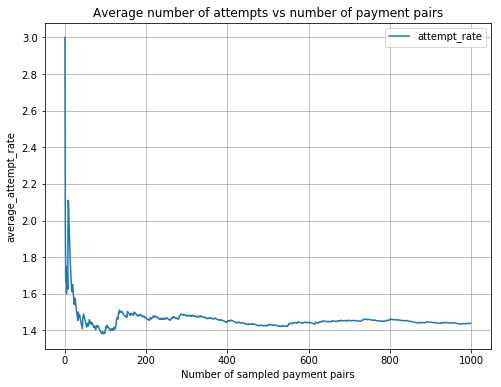

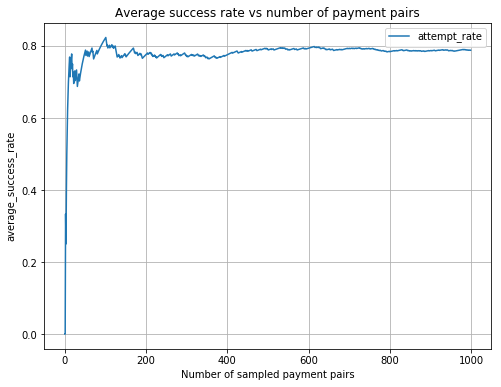

In [120]:
plt.figure(figsize=(8,6))
plt.title("Average number of attempts vs number of payment pairs")
plt.plot(attemp_rate,label="attempt_rate")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("average_attempt_rate")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

plt.figure(figsize=(8,6))
plt.title("Average success rate vs number of payment pairs")
plt.plot(success_rate,label="attempt_rate")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("average_success_rate")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

### How to evaluate split ratio? 

look at theoretical probabilities for all split ratios!
in this way it actually makes sense to look at 1-99 split and 99-1 split!



PAYMENT PAIR NUMBER: 0
0329a46f47--100000-->03864ef025--16777215.0-->0395033b25--40000-->03b38f5fb6
0.0 1.0 

No Path between: 0329a46f47 and 03b38f5fb6
(True, 1) 

PAYMENT PAIR NUMBER: 1
029c21e40c--100000-->03864ef025--10000000.0-->0217890e3a--226996-->021102bc07
0.0 1.0 

No Path between: 029c21e40c and 021102bc07
(True, 1) 

PAYMENT PAIR NUMBER: 2
037ceda65c--41757-->0327e003e3--5000000-->03864ef025--16777215-->03005b000a--50000-->028f0d380f
0.0 1.0 

No Path between: 037ceda65c and 028f0d380f
(True, 1) 

PAYMENT PAIR NUMBER: 3
02628d8e2f--2000000-->03abf6f44c--21177-->0250bfb7e6
0.0 1.0 

02628d8e2f--3000000-->03864ef025--1582102-->02d6647db3--5000000-->0250bfb7e6
1000000.0 0.19622932299512177 

total probability for split: 0.19622932299512177 log 2.349387452011726 


02628d8e2f--3000000-->03864ef025--1582102-->02d6647db3--5000000-->0250bfb7e6
40000.0 0.9540272048575585 

02628d8e2f--2960000.0-->03864ef025--1542102.0-->02d6647db3--4960000.0-->0250bfb7e6
960000.0 0.2056852488021239

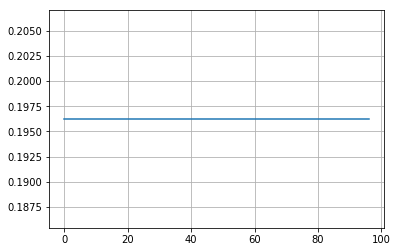

(True, 1) 

PAYMENT PAIR NUMBER: 4
03b5a0226a--61337-->02ad6fb8d6--71337-->03469b295d
0.0 1.0 

03b5a0226a--2250000-->03864ef025--16777215-->03469b295d
1000000.0 0.5224420497706965 

total probability for split: 0.5224420497706965 log 0.9366570751963217 


03b5a0226a--61337.0-->02ad6fb8d6--71337.0-->03469b295d
40000.0 0.15281797704895267 

03b5a0226a--2250000-->03864ef025--16777215-->03469b295d
960000.0 0.540527115627814 

total probability for split: 0.08260226035034786 log 3.597674929296835 


03b5a0226a--2250000-->03864ef025--16777215-->03469b295d
80000.0 0.9598456306902178 

03b5a0226a--2170000.0-->03864ef025--16697215.0-->03469b295d
920000.0 0.544297992370932 

total probability for split: 0.5224420497706966 log 0.9366570751963216 


03b5a0226a--2250000.0-->03864ef025--16777215.0-->03469b295d
120000.0 0.9398956025543335 

03b5a0226a--2130000.0-->03864ef025--16657215.0-->03469b295d
880000.0 0.5558511480965198 

total probability for split: 0.5224420497706965 log 0.9366570751963218 

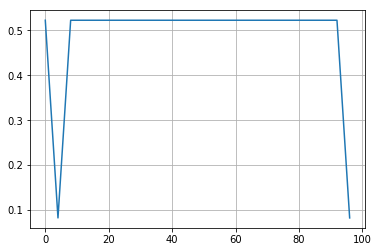

(True, 1) 

PAYMENT PAIR NUMBER: 5
028eb2f891--70000-->02315fe361--500000.0-->035b017b7e--200000-->028dcc199b
0.0 1.0 

No Path between: 028eb2f891 and 028dcc199b
(True, 1) 

PAYMENT PAIR NUMBER: 6
0242a4ae0c--610668-->0298f6074a--1000000-->0328946a06
0.0 1.0 

0242a4ae0c--16777215-->03abf6f44c--16770000.0-->03c436af41--1000000-->0328946a06
1000000.0 8.843184244453282e-07 

total probability for split: 8.843184244453282e-07 log 20.10893071693643 


0242a4ae0c--610668.0-->0298f6074a--1000000.0-->0328946a06
40000.0 0.8971181815791159 

0242a4ae0c--16777215-->03abf6f44c--16770000.0-->03c436af41--1000000-->0328946a06
960000.0 0.03555325539735033 

total probability for split: 0.03189547183128882 log 4.970504569240605 


0242a4ae0c--610668.0-->0298f6074a--1000000.0-->0328946a06
80000.0 0.7994765125681466 

0242a4ae0c--16777215-->03abf6f44c--16770000.0-->03c436af41--1000000-->0328946a06
920000.0 0.07146579559348087 

total probability for split: 0.057135225028984105 log 4.129475719038723 




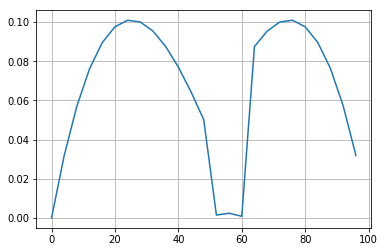

(True, 1) 

PAYMENT PAIR NUMBER: 7
021a302bba--200000-->03bb88ccc4--4000000.0-->023d70f2f7--90000-->031dc4d503
0.0 1.0 

No Path between: 021a302bba and 031dc4d503
(True, 1) 

PAYMENT PAIR NUMBER: 8
0249b0e7f9--200000-->03a503d8e3--20000000.0-->02ad6fb8d6--300000.0-->03634bda49--51006-->0302880b4a
0.0 1.0 

No Path between: 0249b0e7f9 and 0302880b4a
(True, 1) 

PAYMENT PAIR NUMBER: 9
03f7469b18--291342-->0217890e3a--234321-->023d153b51
0.0 1.0 

No Path between: 03f7469b18 and 023d153b51
(True, 1) 



In [179]:
def mpp2_path_planning(src,dest,amt, channel_graph, funded_network):
    xs = []
    ys = []
    for i in range(0,100,4):
        amt_1=i*amt/100
        amt_2=amt - amt_1
        
        prob_graph=create_probability_graph(amt_1, channel_graph)
        path1 = None
        try: 
            path1 = nx.shortest_path(prob_graph,src,dest)
        except:
            print("No Path between: {} and {}".format(src[:10],dest[:10]))
            return False
        
        print_path(path1,channel_graph)
        #p = 0
        l1 = 0
        
        for s,d in next_hop(path1):
            l1+=prob_graph[s][d]["weight"]
            #print(channel_graph[s][d]["cap"], channel_graph[d][s]["cap"])
            channel_graph[s][d]["cap"]-=amt_1
            #print(channel_graph[s][d]["cap"], channel_graph[d][s]["cap"])
        
        p1 = 2**(-l1)
        print(amt_1,p1,"\n")
        
        
        prob_graph=create_probability_graph(amt_2, channel_graph)
        path2 = None
        try: 
            path2 = nx.shortest_path(prob_graph,src,dest)
        except:
            print("No Path between: {} and {}".format(src[:10],dest[:10]))
            for s,d in next_hop(path1):
                channel_graph[s][d]["cap"]+=amt_1

            return False
        
        print_path(path2,channel_graph)
        l2 = 0
        for s,d in next_hop(path2):
            l2+=prob_graph[s][d]["weight"]
        
        p2 = 2**(-l2)
        print(amt_2,p2,"\n")
        
        print("total probability for split:", p1*p2,"log",l1+l2, "\n\n")

        for s,d in next_hop(path1):
            channel_graph[s][d]["cap"]+=amt_1

        xs.append(i)
        ys.append(p1*p2)
    plt.plot(xs,ys)
    plt.grid()
    plt.show()

def find_optimal_split_ratio(n):
    res = []
    nodes = set(channel_graph.nodes())
    for i in range(n):
        print("PAYMENT PAIR NUMBER: {}".format(i))
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        mpp2_path_planning(src, dest, 1000000, channel_graph, funded_network)
        res.append((suc,att))
        print(res[-1],"\n")
    return res
res = find_optimal_split_ratio(10)


## Experiment 3: various splitting strategies

we want to test at least three splitting strategies

### Proposed greedy strategy: 
* compute the theoretic optimal split
* send out onions
* merge failed onions
* update knowledge of the graph
* repeat with the remaining amount

## c-lightning split
* do 10 attempts
* split in half
* repeat each half 

## Binary splitter
* not clear how to implement

# Appendix

let us try on one channel theoretically compute probabilities of switching split order

In [153]:
cap = 1000
for amt in range(100):
    amt2 = 100 - amt
    
    p1=(cap-amt+1)/(cap+1)
    
    c = cap - amt
    
    p2 = (c-amt2 +1)/(c+1)
    
    print(p1,p2,p1*p2)

1.0 0.9000999000999002 0.9000999000999002
0.999000999000999 0.901 0.9000999000999002
0.998001998001998 0.9019019019019019 0.9000999000999
0.997002997002997 0.9028056112224448 0.9000999000999
0.996003996003996 0.9037111334002006 0.9000999000999002
0.995004995004995 0.9046184738955824 0.9000999000999
0.994005994005994 0.9055276381909547 0.9000999000999
0.993006993006993 0.9064386317907445 0.9000999000999002
0.9920079920079921 0.9073514602215509 0.9000999000999002
0.991008991008991 0.9082661290322581 0.9000999000999002
0.99000999000999 0.9091826437941474 0.9000999000999002
0.989010989010989 0.9101010101010101 0.9000999000999002
0.988011988011988 0.9110212335692619 0.9000999000999
0.987012987012987 0.9119433198380567 0.9000999000999
0.986013986013986 0.9128672745694022 0.9000999000999002
0.985014985014985 0.9137931034482759 0.9000999000999002
0.984015984015984 0.9147208121827411 0.9000999000999002
0.983016983016983 0.915650406504065 0.9000999000999002
0.9820179820179821 0.9165818921668362 

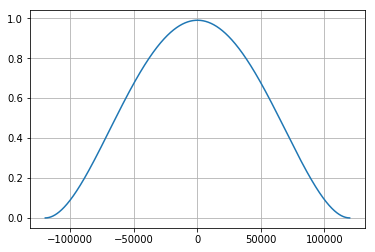

In [164]:
amt = 600
c = 120000

xs = []
ys = []
for split in range(amt -c,c):
    a = split
    b = amt -split
    p1 = ((c-a)/c)**2
    p2 = ((c-b)/c)**2
    res = p1*p2
    xs.append(split)
    ys.append(res)

plt.plot(xs,ys)
plt.grid()
plt.show()

Example for a non optimal 50/50 split. 
lets deliver the amount 100
lets have two paths that have identical probabilities beside two channels which impose the bottlenecks. 

channel 1 has a capacity of 80
channel 2 has a capacity of 100

In [180]:
a = 100
c1 = 80
c2 = 100

In [186]:
amounts = [i for i in range(a)]

def uniform_success_probability(a,c):
    if a <= c:
        return (c+1-a)/(c+1)
    else: 
        return 0

In [211]:
p1 = [uniform_success_probability(a,c1) for a in amounts]
p2 = [uniform_success_probability(a,c2) for a in amounts]


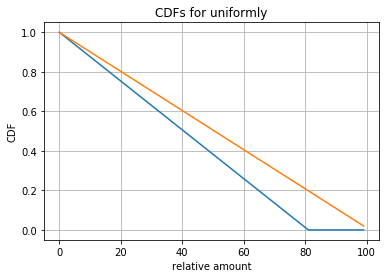

In [201]:
plt.title("CDFs for uniformly")
plt.plot(amounts,p1)
plt.plot(amounts,p2)
plt.grid()
plt.xlabel("relative amount")
plt.ylabel("CDF")
plt.show()

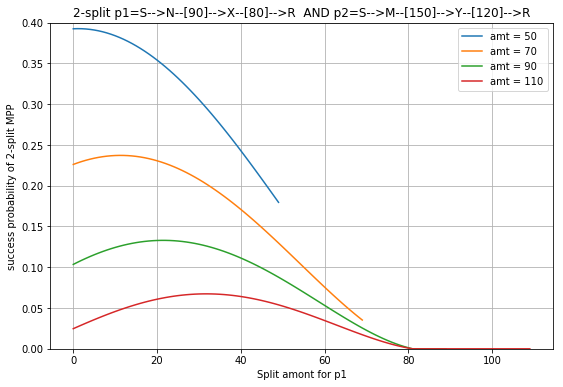

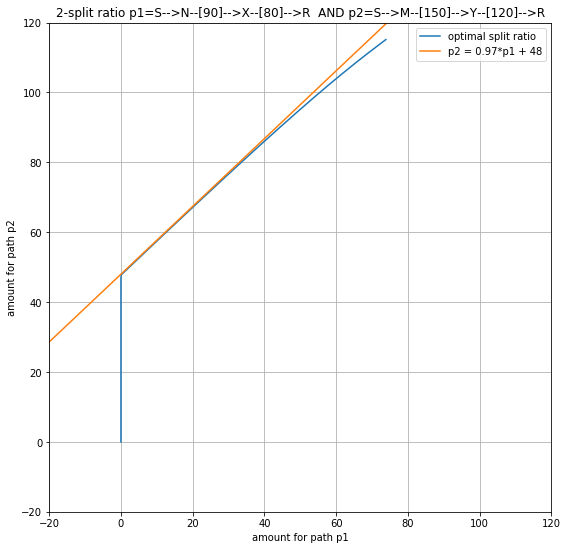

In [287]:
c1 = 90
c2 = 80
d1 = 150
d2 = 120
a = 110
amounts = [i for i in range(a)]
mpp_probs = []
for a1 in range(a):
    p1 =  uniform_success_probability(a1,c1)*uniform_success_probability(a1,c2)
    p2 =  uniform_success_probability(a-a1,d1)*uniform_success_probability(a-a1,d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)
    

plt.figure(figsize=(9,6))
plt.title("2-split p1=S-->N--[{}]-->X--[{}]-->R  AND p2=S-->M--[{}]-->Y--[{}]-->R".format(c1,c2,d1,d2))

a = 50
amounts = [i for i in range(a)]
mpp_probs = []
for a1 in range(a):
    p1 =  uniform_success_probability(a1,c1)*uniform_success_probability(a1,c2)
    p2 =  uniform_success_probability(a-a1,d1)*uniform_success_probability(a-a1,d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)
plt.plot(amounts,mpp_probs,label="amt = {}".format(a))
a = 70
amounts = [i for i in range(a)]
mpp_probs = []
for a1 in range(a):
    p1 =  uniform_success_probability(a1,c1)*uniform_success_probability(a1,c2)
    p2 =  uniform_success_probability(a-a1,d1)*uniform_success_probability(a-a1,d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)
plt.plot(amounts,mpp_probs,label="amt = {}".format(a))
a = 90
amounts = [i for i in range(a)]
mpp_probs = []
for a1 in range(a):
    p1 =  uniform_success_probability(a1,c1)*uniform_success_probability(a1,c2)
    p2 =  uniform_success_probability(a-a1,d1)*uniform_success_probability(a-a1,d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)
plt.plot(amounts,mpp_probs,label="amt = {}".format(a))

a = 110
amounts = [i for i in range(a)]
mpp_probs = []
for a1 in range(a):
    p1 =  uniform_success_probability(a1,c1)*uniform_success_probability(a1,c2)
    p2 =  uniform_success_probability(a-a1,d1)*uniform_success_probability(a-a1,d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)
plt.plot(amounts,mpp_probs,label="amt = {}".format(a))
"""
xs = []
mpp_probs = []
for a1 in range(190):
    xs.append(split_value[a1])
    p1 =  uniform_success_probability(split_value[a1],c1)*uniform_success_probability(split_value[a1],c2)
    p2 =  uniform_success_probability(a1-split_value[a1],d1)*uniform_success_probability(a1-split_value[a1],d2)
    mpp_prob = p1*p2
    mpp_probs.append(p1*p2)

plt.plot(xs,mpp_probs,"x",label="probability best split")
"""
plt.grid()
plt.xlabel("Split amont for p1")
plt.ylabel("success probability of 2-split MPP")
plt.ylim(0.0,0.4)
#plt.yscale("log")
plt.legend()
plt.savefig("../../paper/img/optimal_split_example_amounts.png")
plt.show()    


    
plt.figure(figsize=(9,9))
plt.title("2-split ratio p1=S-->N--[{}]-->X--[{}]-->R  AND p2=S-->M--[{}]-->Y--[{}]-->R".format(c1,c2,d1,d2))

xs = []
mpp_probs = []
for a1 in range(190):
    xs.append(split_value[a1])
    mpp_probs.append(a1-split_value[a1])
plt.plot(xs,mpp_probs,"-",label="optimal split ratio")

xs = []
ys = []
for a1 in range(-20,190):
    xs.append(a1)
    ys.append(0.97*a1+48)
plt.plot(xs,ys,"-",label="p2 = 0.97*p1 + 48")


plt.grid()
plt.xlabel("amount for path p1")
plt.ylabel("amount for path p2")
plt.legend()
plt.xlim(-20,120)
plt.ylim(-20,120)
plt.savefig("../../paper/img/optimal_split_example.png")
plt.show()

In [258]:

a1, a2, l = symbols('a1 a2 l')

c = min(c1,c2)
d = min(d1,d2)

split_value = []
amt = 190
for a in range(0,amt):
    res = nsolve([Eq((2*a1-(c1+c2+2))*(a2**2-(d1+d2+2)*a2 + (d1+1)*(d2+1)), l),
       Eq((2*a2-(d1+d2+2))*(a1**2 -(c1+c2+2)*a1 + (c1+1)*(c2+1)), l),
       Eq(a1+a2, a)], [a1,a2,l], (a * c/(c+d),a * d/(c+d),1), simplify=False)
    print(a,res[0],res[1])
    if res[0]<0:
        split_value.append(0)
    else:
        split_value.append(res[0])

## NEED tool to transfer path to set of equations including derrivatives instead of doing this by hand!


0 -24.1080901882508 24.1080901882508
1 -23.6041349791780 24.6041349791780
2 -23.1001448958724 25.1001448958724
3 -22.5961194799629 25.5961194799629
4 -22.0920582651001 26.0920582651001
5 -21.5879607767843 26.5879607767843
6 -21.0838265321888 27.0838265321888
7 -20.5796550399785 27.5796550399785
8 -20.0754458001241 28.0754458001241
9 -19.5711983037114 28.5711983037114
10 -19.0669120327452 29.0669120327452
11 -18.5625864599489 29.5625864599489
12 -18.0582210485583 30.0582210485583
13 -17.5538152521098 30.5538152521098
14 -17.0493685142232 31.0493685142232
15 -16.5448802683789 31.5448802683789
16 -16.0403499376891 32.0403499376891
17 -15.5357769346625 32.5357769346625
18 -15.0311606609630 33.0311606609630
19 -14.5265005071617 33.5265005071617
20 -14.0217958524825 34.0217958524825
21 -13.5170460645404 34.5170460645404
22 -13.0122504990727 35.0122504990727
23 -12.5074084996632 35.5074084996631
24 -12.0025193974578 36.0025193974578
25 -11.4975825108739 36.4975825108739
26 -10.9925971453000 3

In [253]:
for r in res:
    print(r)
    print("\n")
split_value

31.2047114210059


77.7952885789941


-346611.809647935




[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.130939238098618,
 0.637266543406949,
 1.14366385781247,
 1.65013232911821,
 2.15667312987357,
 2.66328745803046,
 3.16997653761997,
 3.67674161945014,
 4.18358398182577,
 4.69050493129088,
 5.19750580339477,
 5.70458796348246,
 6.21175280751038,
 6.71900176288827,
 7.22633628934825,
 7.73375787984194,
 8.24126806146680,
 8.74886839642272,
 9.25656048299987,
 9.76434595659911,
 10.2722264907861,
 10.7802037983804,
 11.2882796325807,
 11.7964557881277,
 12.3047341025064,
 12.8131164571880,
 13.3216047789150,
 13.8302010410287,
 14.3389072648429,
 14.8477255210641,
 15.3566579312607,
 15.8657066693823,
 16.3748739633326,
 16.8841620965958,
 17.3935734099203,
 17.9031103030610,
 18.4127752365829,
 18.9225707337282,
 19.4324993823491,
 19.9425638369089,
 20.4527668205553,
 20.9631111272662,
 21.4735

In [9]:
def uniform_probability(capacities,var):
    x = symbols(var)
    eq = 1
    for cap in capacities:
        eq=eq*((cap+1-x)/(cap+1))
    return x, eq

In [65]:
#candidate selection will work as follows for now: take the amount / k 
# compute most likely path
# remove edges select next

def max_probable_path(src,dest,amt, channel_graph, funded_network):
    prob_graph=create_probability_graph(amt, channel_graph)
    
    if src not in prob_graph:
        print("No Path between: {} and {}".format(src[:10],dest[:10]))
        return None
        
    
    impossible_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                      if funded_network[src][neighbor]["capacity"]<amt] 
    certain_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                   if funded_network[src][neighbor]["capacity"]>=amt]     
    ##TODO: this is the issue! the update function can remove an edge and a node if the degree is low
    update_graph(certain_edges,impossible_edges,prob_graph)
    
    path = None
    try: 
        return nx.shortest_path(prob_graph,src,dest)
    except:
        print("No Path between: {} and {}".format(src[:10],dest[:10]))
        return None

def create_and_solve_lagrange_problem(eqs,variables,amt,mins):
    print(amt,variables,eqs)
    P = 1
    for eq in eqs:
        P=P*eq
    print(P)
    partial_derrivatives = [diff(P,var) for var in variables]
    l = symbols("l")
    non_linear_equations = [Eq(p,l) for p in partial_derrivatives]
    split = 0
    for var in variables:
        split=split+var
    variables.append(l)
    non_linear_equations.append(Eq(split,amt))
    s = sum(mins)
    start = [amt*m/s for m in mins]
    start.append(1)
    print(non_linear_equations,split, start)
    print((P).evalf(subs=dict(zip(variables[:-1],start))))
    res = nsolve(non_linear_equations,variables,start, simplify=False)
    print(amt, res)
    subs=dict(zip(variables[:-1],res[:-1]))
    print((P).evalf(subs = subs))
    return res


In [17]:


"""
p1 = diff(eq1*eq2,x)
p2 = diff(eq1*eq2,y)
l=symbols("l")

for a in range(10000,10001):
    res = nsolve([Eq(p1, l),
       Eq(p2, l),
       Eq(x+y, a)], [x,y,l], (a/2,a/2,1), simplify=False)
    subs=dict(zip([x,y],[res[0],res[1]]))
    print(a,res[0],res[1],(eq1*eq2).evalf(subs = subs))
    if (res[0]<0 or res[1]<0):
        print("\t",eq1.evalf(subs={x:a}),eq2.evalf(subs={y:a}))
"""
def update_capacities_of_path(channel_graph,path,x,key=None):
    for src,dest in next_hop(path):
        if key is None:
            channel_graph[src][dest]["cap"]+=x
        else:
            channel_graph[src][dest][key]+=x
                   
    
def find_most_likely_kpp(s,d,a):
    for k in range(1,5):
        print("\ncomputing {}pp-split".format(k))
        eqs = []
        variables = []
        used_edges = []
        paths = []
        mins = []
        for p in range(k):
            path = max_probable_path(s,d,a/k,channel_graph,funded_network)
            if path is not None:
                caps = [channel_graph[src][dest]["cap"] for src,dest in next_hop(path)]

                update_capacities_of_path(channel_graph,path,-a/k)
                update_capacities_of_path(funded_network,path,-a/k,"capacity")
                update_capacities_of_path(funded_network,path,-a/k)
                
                #for src,dest in next_hop(path):
                #    channel_graph[src][dest]["cap"]-=a/k
                mins.append(min(caps[1:]))
                var, eq = uniform_probability(caps[1:],"x{}".format(p+1))
                eqs.append(eq)
                variables.append(var)
                print_path(path,channel_graph)
                
                #DisjointPATHS
                #for src,dest in next_hop(path):
                #    used_edges.append((src,dest,channel_graph[src][dest]["cap"]))
                #    channel_graph.remove_edge(src,dest)
                
                paths.append(path)
                print(eq.evalf(subs={var:a/k}))
            else:
                for path in paths:
                    update_capacities_of_path(channel_graph,path,a/k)
                    update_capacities_of_path(funded_network,path,a/k,"capacity")
                    update_capacities_of_path(funded_network,path,a/k)

                
                #DisjointPATHS
                #for src,dest,cap in used_edges:
                #    channel_graph.add_edge(src,dest,cap=cap)
                return
        if k>1:
            create_and_solve_lagrange_problem(eqs,variables,a,mins)
        #enter edges again 
        for path in paths:
            update_capacities_of_path(channel_graph,path,a/k)

        #DisjointPATH
        #for src,dest,cap in used_edges:
        #    channel_graph.add_edge(src,dest,cap=cap)
        
        #break
for i in range(10):
    print("PAYMENT PAIR NUMBER: {}".format(i))
    n = [x for x in channel_graph.nodes() if len(list(channel_graph.neighbors(x)))>10]
    print(len(n), "nodes to sample from")
    payment_pair = random.sample(n,2)
    src, dest = payment_pair
    find_most_likely_kpp("03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df",dest,1000000)

PAYMENT PAIR NUMBER: 0
891 nodes to sample from

computing 1pp-split
03efccf2c3--5500000.0-->03abf6f44c--4000000.0-->02d419c9af--1100000.0-->028691404b
0.419047821405814

computing 2pp-split
03efccf2c3--5700000.0-->033d865621--7500000.0-->02445ff6a2--0.0-->028691404b
1.87499626563247e-6
03efccf2c3--6000000.0-->03abf6f44c--2527640.0-->0217890e3a--0.0-->028691404b
1.66970651059892e-6
1000000 [x1, x2] [(-x1/500001 + 1)*(-x1/8000001 + 1), (-x2/500001 + 1)*(-x2/3027641 + 1)]
(-x1/500001 + 1)*(-x1/8000001 + 1)*(-x2/500001 + 1)*(-x2/3027641 + 1)
[Eq(-(-x1/500001 + 1)*(-x2/500001 + 1)*(-x2/3027641 + 1)/8000001 - (-x1/8000001 + 1)*(-x2/500001 + 1)*(-x2/3027641 + 1)/500001, l), Eq(-(-x1/500001 + 1)*(-x1/8000001 + 1)*(-x2/500001 + 1)/3027641 - (-x1/500001 + 1)*(-x1/8000001 + 1)*(-x2/3027641 + 1)/500001, l), Eq(x1 + x2, 1000000)] x1 + x2 [500000.0, 500000.0, 1]
3.13069347207519e-12
1000000 Matrix([[500000.000000131], [499999.999999869], [-3.13069430012048e-12]])
3.13069347207524e-12

computing 3pp

03efccf2c3--2250000.0-->021607cfce--1750000.0-->029a874167--750000.0-->03688e7385
0.656250265624773
03efccf2c3--2000000.0-->021607cfce--1500000.0-->029a874167--500000.0-->03688e7385
0.571429006802218
03efccf2c3--1750000.0-->021607cfce--1250000.0-->029a874167--250000.0-->03688e7385
0.416667555553963
03efccf2c3--1500000.0-->021607cfce--1000000.0-->029a874167--0.0-->03688e7385
3.19998784000956e-6
1000000 [x1, x2, x3, x4] [(-9.99999000001e-7*x1 + 1.0)*(-4.99999750000125e-7*x1 + 1.0), (-1.33333155555793e-6*x2 + 1.0)*(-5.71428244898146e-7*x2 + 1.0), (-1.999996000008e-6*x3 + 1.0)*(-6.66666222222519e-7*x3 + 1.0), (-3.999984000064e-6*x4 + 1.0)*(-7.99999360000512e-7*x4 + 1.0)]
(-9.99999000001e-7*x1 + 1.0)*(-4.99999750000125e-7*x1 + 1.0)*(-1.33333155555793e-6*x2 + 1.0)*(-5.71428244898146e-7*x2 + 1.0)*(-1.999996000008e-6*x3 + 1.0)*(-6.66666222222519e-7*x3 + 1.0)*(-3.999984000064e-6*x4 + 1.0)*(-7.99999360000512e-7*x4 + 1.0)
[Eq(-4.99999750000125e-7*(-9.99999000001e-7*x1 + 1.0)*(-1.33333155555793e-6

1000000 Matrix([[436771.552940921], [186771.553318735], [-63228.4471817478], [439685.340922092], [-3.34333595933403e-7]])
0.122564225972977
PAYMENT PAIR NUMBER: 3
891 nodes to sample from

computing 1pp-split
03efccf2c3--15777215.0-->02247d9db0--9000000.0-->03fab7f865--221929.0-->032434517e
0.163460265497451

computing 2pp-split
03efccf2c3--500000.0-->03ad1b3bbc--500000.0-->032cc4541b--3386482.0-->032434517e
0.435674925952283


KeyboardInterrupt: 

In [394]:
for src, dest prob.neighbors("022ff65ac5689256dfa9301f9b6fac53feacb07eaad5cd095fa95d3ddfedba91fc"):
    print(src,dest)

In [32]:
rene = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
for n in funded_network.neighbors("03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"):
    print(n[:10],funded_network[rene][n])

0242a4ae0c {'cap': 685228, 'capacity': 467882}
03abf6f44c {'cap': 7000000, 'capacity': 4338320}
024a8228d7 {'cap': 261432, 'capacity': 47442}
02247d9db0 {'cap': 16777215, 'capacity': 4335945}
032679fec1 {'cap': 9000000, 'capacity': 4490584}
0284383337 {'cap': 300000, 'capacity': 0}
0249fe70a4 {'cap': 400000, 'capacity': 188292}
02e7c42ae2 {'cap': 485003, 'capacity': 28938}
03ad6cd751 {'cap': 226043, 'capacity': 175439}
02e1f8a072 {'cap': 50000, 'capacity': 30745}
03ad1b3bbc {'cap': 1000000, 'capacity': 621880}
02f2db91d9 {'cap': 1251349, 'capacity': 13903}
033d865621 {'cap': 6200000, 'capacity': 5975820}
02731b798b {'cap': 2000000, 'capacity': 726897}
027d0de66d {'cap': 197475, 'capacity': 19348}
02f31ff9c5 {'cap': 1000000, 'capacity': 1000000}
03c4ffc2c7 {'cap': 1000000, 'capacity': 1000000}
02a2960600 {'cap': 200000, 'capacity': 63250}
03cde60a63 {'cap': 10000000, 'capacity': 4393598}
03fcf9e536 {'cap': 537818, 'capacity': 533041}
023662f1db {'cap': 499820, 'capacity': 418986}
02a84d

PAYMENT PAIR NUMBER: 0
computing 1pp-split
036fb07937--150000-->0395033b25--344993-->0217890e3a--273316-->027c4afa4b
0.935486963668960
computing 2pp-split
036fb07937--150000-->0395033b25--344993-->0217890e3a--273316-->027c4afa4b
0.967478350033760
036fb07937--239000-->03ee1bf829--2500000-->039edc9498--342447.0-->02ad6fb8d6--364748.0-->02004c625d--1000000-->027c4afa4b
0.965097819524442
computing 3pp-split
036fb07937--150000-->0395033b25--344993-->0217890e3a--273316-->027c4afa4b
0.978259981844569
036fb07937--239000-->03ee1bf829--2500000-->039edc9498--342447.0-->02ad6fb8d6--364748.0-->02004c625d--1000000-->027c4afa4b
0.976641767043755

In [2]:
0.967478350033760*0.965097819524442

0.9337112460546866

In [14]:
x, eq1 = uniform_probability([1500000,500000],"x")
y, eq2 = uniform_probability([2000000,600000,100000],"y")
print(eq1*eq2)



(-x/500001 + 1)*(-x/1500001 + 1)*(-y/100001 + 1)*(-y/600001 + 1)*(-y/2000001 + 1)


In [16]:
p1 = diff(eq1*eq2,x)
p2 = diff(eq1*eq2,y)
l=symbols("l")

for a in range(10000,10001):
    res = nsolve([Eq(p1, l),
       Eq(p2, l),
       Eq(x+y, a)], [x,y,l], (a/2,a/2,1), simplify=False)
    subs=dict(zip([x,y],[res[0],res[1]]))
    

    
    print(a,res[0],res[1],(eq1*eq2).evalf(subs = subs))
    if (res[0]<0 or res[1]<0):
        print("\t",eq1.evalf(subs={x:a}),eq2.evalf(subs={y:a}))
    #print(N(eq1*eq2,(res[0],res[1])))


10000 241663.286782707 -231663.286782707 2.22336977795715
	 0.973466710755473 0.880576005494370


In [18]:
#print("algebraic:\n",solve([Eq(p1, l),
#                            Eq(p2, l),
#                            Eq(x+y, a)], [x,y,l]))


algebraic:
 [((19136641832326219596553260833785275263311434056802957323225417101703624960984140133309739847023677801567787606304167748295296659276856186793430035588517739025286656568840379259103718675861880108292487694648560097761033389343327219327482951885915478667106153488677746445026179728163446086298193773383419866232645080226961787128198258226145681246830918020728127838601919809650670159340812969760548034757378168382177066031578776849418871644441904303642299196134319817017214353711847484164697289947149251941923805679230662035046342753219066073390174875993273264545793773437500000000 - 56898214041457889534915818591365474462429723976084287193268845130337896378095517119498886580792136866076224121958683475857224197187873274562304832885787133996537505165250765230978729903094897213787138489141997871285790585718354307454941899126746380353716143537536985471428635956528378936866911959049522216296235892966293918846340810730769820282747181464463773422889611592940126149470208979038992728100982

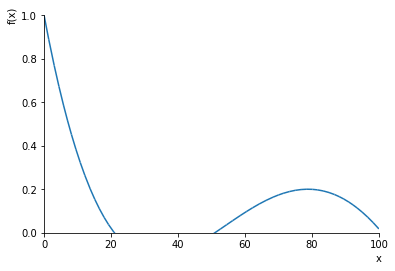

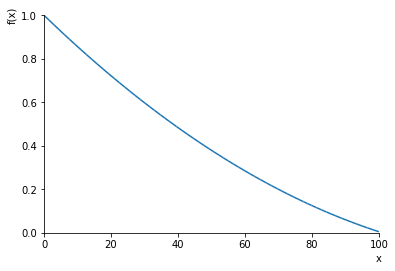

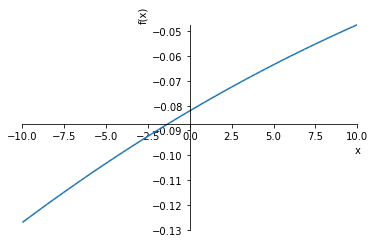

In [309]:

eq
plot(eq,(x,0,100),xlim=(0,100),ylim=(0,1))
p1.show()
plot(diff(eq))

In [301]:
diff(eq)

2*x/20301 - 302/20301

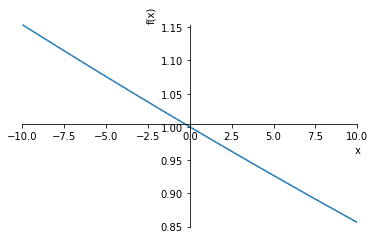

# building up 1 sat split finder

In [68]:
def path_probability(path,prob_graph):
    l = 0
    for s,d in next_hop(path):
        l-=prob_graph[s][d]["weight"]
    return 2**l

def get_updated_channel_graph(channel_graph,mpp_split):
    tmp_channel_graph = channel_graph.copy()
    for k, v in mpp_split.items():
        path, amt, prob = v
        for src, dest in next_hop(path):
            tmp_channel_graph[src][dest]["cap"] -= amt
    return tmp_channel_graph

def path_part_of_mpp(test_path,mpp_split):
    for k,v in mpp_split.items():
        path,amt,prob = v
        if len(path) == len(test_path):
            flag = True
            for i in range(len(path)):
                if path[i]!=test_path[i]:
                    flag = False
                    break
            if flag:
                return k
    return None

def compute_best_split(channel_graph,mpp_split,curr_amt):
    #we could solve the optimization problem here but we use a heuristic here first
    mins = []
    eqs = []
    variables = []
    for k,v in mpp_split.items():
        path,amt,prob = v
        caps = [channel_graph[src][dest]["cap"] for src,dest in next_hop(path)]
        mins.append(min(caps))
        
        #does not account for non disjoint paths yet
        var, eq = uniform_probability(caps,"x{}".format(k))
        eqs.append(eq)
        variables.append(var)
        create_and_solve_lagrange_problem(eqs,variables,curr_amt,mins)        


In [70]:
def build_kpp(s,d,amt):
    mpp_split = {}
    curr_amt = 131072
    
    tmp_channel_graph = get_updated_channel_graph(channel_graph,mpp_split)
    while curr_amt < amt:
        tmp_channel_graph = get_updated_channel_graph(channel_graph,mpp_split)
        prob_graph = create_probability_graph(curr_amt,tmp_channel_graph)
        path = nx.shortest_path(prob_graph,s,d,weight="weight")
        key = path_part_of_mpp(path,mpp_split)
        if key is not None:
            print("yes!")
            tmp_channel_graph = get_updated_channel_graph(channel_graph,mpp_split)
            #increase the amount
            if curr_amt < amt / 2:
                curr_amt *= 2
            else:
                curr_amt=amt-1
            prob_graph = create_probability_graph(curr_amt, channel_graph)
            mpp_split[key]=(path,curr_amt,path_probability(path,prob_graph))
            

            
        else:
            l = len(mpp_split)
            mpp_split[l] = (path,None,None)
            if l==0:
                mpp_split[l] = (path,curr_amt,path_probability(path, prob_graph))
            if l > 0:
                mpp_split[l] = (path,curr_amt,path_probability(path, prob_graph))
                print_path(path,channel_graph)
                compute_best_split(channel_graph,mpp_split,curr_amt)

        print_path(path,channel_graph)
        print(path_probability(path,prob_graph))
        print(mpp_split)
    return

    
    num_paths = 1
    curr_amt = 1
    prob_graph = create_probability_graph(curr_amt,channel_graph)
    paths_generator = nx.shortest_simple_paths(prob_graph,s,d,weight="weight")
    
    paths = []
    for i,path in enumerate(paths):
        if i==num_paths + 1:
            break
        paths.append(path)
        
    while curr_amt < a:
        curr_amt *= 2
        prob_graph = create_probability_graph(curr_amt,channel_graph)
        paths_generator = nx.shortest_simple_paths(prob_graph,s,d,weight="weight")
        
for i in range(10):
    print("PAYMENT PAIR NUMBER: {}".format(i))
    #n = [x for x in channel_graph.nodes() if len(list(channel_graph.neighbors(x)))>10]
    #print(len(n), "nodes to sample from")
    #payment_pair = random.sample(n,2)
    src, dest = payment_pair
    build_kpp("03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df",dest,1000000)
    
#03efccf2c3--485003-->02e7c42ae2--400003-->0231eccc65


PAYMENT PAIR NUMBER: 0
03efccf2c3--10000000-->03cde60a63--500000000-->0288be11d1--16777215-->0231eccc65
0.985344957285522
{0: (['03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df', '03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6', '0288be11d147e1525f7f234f304b094d6627d2c70f3313d7ba3696887b261c4447', '0231eccc6510eb2e1c97c8a190d6ea096784aa7c358355442055aac8b20654f932'], 131072, 0.985344957285522)}
yes!
03efccf2c3--10000000-->03cde60a63--500000000-->0288be11d1--16777215-->0231eccc65
0.970744206730642
{0: (['03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df', '03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6', '0288be11d147e1525f7f234f304b094d6627d2c70f3313d7ba3696887b261c4447', '0231eccc6510eb2e1c97c8a190d6ea096784aa7c358355442055aac8b20654f932'], 262144, 0.970744206730642)}
yes!
03efccf2c3--10000000-->03cde60a63--500000000-->0288be11d1--16777215-->0231eccc65
0.941706231434293
{0: (['03efccf2c383d7bf340da9a3f02e2c231

TypeError: nsolve expected exactly 4 guess vectors, got 3

In [ ]:
03efccf2c3--10000000-->03cde60a63--500000000-->0288be11d1--16777215-->0231eccc65


Two interesting results: (especially the second one shows that spliting can be better than not but we have non monotonic probabilities given the splits)


### idea: we could also compute the equisplit probability (which we use to compute candidate paths)


## summary of second payment 
computing 1pp-split
03efccf2c3--1000000-->02f31ff9c5--2500000-->0309bd6a02--2500000-->02c1ac5cee--1000000-->02044b0f26
3.59999832000117e-7

computing 2pp-split

03efccf2c3--5500000-->02537e3176--1000000-->03abf6f44c--544145-->02044b0f26
0.0405645214206811
03efccf2c3--1000000-->02f31ff9c5--2500000-->0309bd6a02--2500000-->02c1ac5cee--1000000-->02044b0f26
0.320000383999722

[352392.4242865793, 647607.5757134208, 1]
0.0441523318240950
[263776.522957354], [736223.477042646]]
0.0498046282254702

computing 3pp-split
03efccf2c3--5500000-->02537e3176--1000000-->03abf6f44c--544145-->02044b0f26
0.258279667678521
03efccf2c3--999000-->03024a36dd--2750000-->02ad6fb8d6--339069-->02c1ac5cee--1000000-->02044b0f26
0.00991204550647960
03efccf2c3--1000000-->02f31ff9c5--2000000-->03bb88ccc4--5000000-->0331f80652--510000-->02044b0f26
0.269427316591479

start_split = [390568.13956793427, 243371.80074274304, 366060.05968932266]
0.00715472198927931
final_split = [408112.177704929], [203787.426642203], [388100.395652868]
0.00773334699904322


computing 4pp-split
03efccf2c3--971000-->032f46d1e9--1230000-->03abf6f44c--544145-->02044b0f26
0.430693740739720
03efccf2c3--999000-->03024a36dd--2750000-->02ad6fb8d6--339069-->02c1ac5cee--1000000-->02044b0f26
0.179106284560870
03efccf2c3--5500000-->02537e3176--1000000-->02445ff6a2--4000000-->0331f80652--510000-->02044b0f26
0.358456683633092
03efccf2c3--1000000-->02f31ff9c5--1000000-->0298f6074a--1000000-->03d5a8b99b--2550000-->02044b0f26
0.507353301037786

start_split = [227369.97192896248, 141679.34835748078, 213102.54745292314, 417848.13226063363]
0.0276386999794672
final_split = [265244.852074703], [28963.4383495691], [190000.650394098], [515791.059181630]
0.0319857758285183


## both payments



PAYMENT PAIR NUMBER: 0
889 nodes to sample from

computing 1pp-split
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0213c1c382)
03efccf2c3--5500000-->02537e3176--2000000-->03864ef025--16777215-->02de11c748
0.470197912711026

computing 2pp-split
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--999000-->03024a36dd--1000000-->032cc4541b--2800000-->02de11c748
0.410714728315936
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--5500000-->02537e3176--2000000-->03864ef025--16777215-->02de11c748
0.727648379483878
1000000 [x1, x2] [(-x1/1000001 + 1)*(-x1/2800001 + 1), (-x2/2000001 + 1)*(-x2/16777216 + 1)]
(-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)
[Eq(-(-x1/1000001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)/2800001 - (-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)/1000001, l), Eq(-(-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)/16777216 - (-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/16777216 + 1)/2000001, l), Eq(x1 + x2, 1000000)] x1 + x2 [333333.3333333333, 666666.6666666666, 1]
0.375976512778770
1000000 Matrix([[-135794.369975411], [1135794.36997541], [-5.85799781531922e-7]])
0.479745558298873

computing 3pp-split
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--999000-->03024a36dd--1000000-->032cc4541b--2800000-->02de11c748
0.587301909296763
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--5500000-->02537e3176--2000000-->03864ef025--16777215-->02de11c748
0.816776569239999
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--719730-->0346fbeec5--1000000-->033ac2f9f7--1000000-->03d37fca06--16777215-->02de11c748
0.435614562313742
1000000 [x1, x2, x3] [(-x1/1000001 + 1)*(-x1/2800001 + 1), (-x2/2000001 + 1)*(-x2/16777216 + 1), (-x3/1000001 + 1)**2*(-x3/16777216 + 1)]
(-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)*(-x3/1000001 + 1)**2*(-x3/16777216 + 1)
[Eq(-(-x1/1000001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)*(-x3/1000001 + 1)**2*(-x3/16777216 + 1)/2800001 - (-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)*(-x3/1000001 + 1)**2*(-x3/16777216 + 1)/1000001, l), Eq(-(-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x3/1000001 + 1)**2*(-x3/16777216 + 1)/16777216 - (-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/16777216 + 1)*(-x3/1000001 + 1)**2*(-x3/16777216 + 1)/2000001, l), Eq(-(-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)*(-x3/1000001 + 1)**2/16777216 + (-x1/1000001 + 1)*(-x1/2800001 + 1)*(-x2/2000001 + 1)*(-x2/16777216 + 1)*(-x3/16777216 + 1)*(2*x3/1000002000001 - 2/1000001), l), Eq(x1 + x2 + x3, 1000000)] x1 + x2 + x3 [250000.0, 500000.0, 250000.0, 1]
0.275402426498413
1000000 Matrix([[1001950.07392958], [-1003268.82333544], [1001318.74940586], [-5.04640164514107e-15]])
-3.25235905409237e-9

computing 4pp-split
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--971000-->032f46d1e9--1719846-->02ad6fb8d6--330335-->02de11c748
0.207843580579841
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--999000-->03024a36dd--1000000-->032cc4541b--2800000-->02de11c748
0.683035965879874
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--5500000-->02537e3176--2000000-->03864ef025--16777215-->02de11c748
0.861961545524030
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--719730-->0346fbeec5--250000-->02c0b38022--250000-->02de11c748
1.59998720007680e-11
1000000 [x1, x2, x3, x4] [(-x1/330336 + 1)*(-x1/1719847 + 1), (-x2/1000001 + 1)*(-x2/2800001 + 1), (-x3/2000001 + 1)*(-x3/16777216 + 1), (-x4/250001 + 1)**2]
(-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2
[Eq(-(-x1/330336 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2/1719847 - (-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2/330336, l), Eq(-(-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2/2800001 - (-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2/1000001, l), Eq(-(-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x4/250001 + 1)**2/16777216 - (-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/16777216 + 1)*(-x4/250001 + 1)**2/2000001, l), Eq((-x1/330336 + 1)*(-x1/1719847 + 1)*(-x2/1000001 + 1)*(-x2/2800001 + 1)*(-x3/2000001 + 1)*(-x3/16777216 + 1)*(2*x4/62500500001 - 2/250001), l), Eq(x1 + x2 + x3 + x4, 1000000)] x1 + x2 + x3 + x4 [92263.71275313623, 279303.47299903503, 558606.9459980701, 69825.86824975876, 1]
0.160130448975148
1000000 Matrix([[327459.778065526], [984711.288753435], [-559977.615032208], [247806.548213247], [5.45290853970495e-15]])
7.12126154697073e-9
PAYMENT PAIR NUMBER: 1
889 nodes to sample from

computing 1pp-split
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0213c1c382)
03efccf2c3--1000000-->02f31ff9c5--2500000-->0309bd6a02--2500000-->02c1ac5cee--1000000-->02044b0f26
3.59999832000117e-7

computing 2pp-split
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--5500000-->02537e3176--1000000-->03abf6f44c--544145-->02044b0f26
0.0405645214206811
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--1000000-->02f31ff9c5--2500000-->0309bd6a02--2500000-->02c1ac5cee--1000000-->02044b0f26
0.320000383999722
1000000 [x1, x2] [(-x1/544146 + 1)*(-x1/1000001 + 1), (-x2/1000001 + 1)*(-x2/2500001 + 1)**2]
(-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/1000001 + 1)*(-x2/2500001 + 1)**2
[Eq(-(-x1/544146 + 1)*(-x2/1000001 + 1)*(-x2/2500001 + 1)**2/1000001 - (-x1/1000001 + 1)*(-x2/1000001 + 1)*(-x2/2500001 + 1)**2/544146, l), Eq((-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/1000001 + 1)*(2*x2/6250005000001 - 2/2500001) - (-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/2500001 + 1)**2/1000001, l), Eq(x1 + x2, 1000000)] x1 + x2 [352392.4242865793, 647607.5757134208, 1]
0.0441523318240950
1000000 Matrix([[263776.522957354], [736223.477042646], [-2.45287965712711e-7]])
0.0498046282254702

computing 3pp-split
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--5500000-->02537e3176--1000000-->03abf6f44c--544145-->02044b0f26
0.258279667678521
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--999000-->03024a36dd--2750000-->02ad6fb8d6--339069-->02c1ac5cee--1000000-->02044b0f26
0.00991204550647960
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,0213c1c382)
removing (03efccf2c3,032f46d1e9)
03efccf2c3--1000000-->02f31ff9c5--2000000-->03bb88ccc4--5000000-->0331f80652--510000-->02044b0f26
0.269427316591479
1000000 [x1, x2, x3] [(-x1/544146 + 1)*(-x1/1000001 + 1), (-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1), (-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)]
(-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)
[Eq(-(-x1/544146 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/1000001 - (-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/544146, l), Eq(-(-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/2750001 - (-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/1000001 - (-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/339070, l), Eq(-(-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/2000001 + 1)/5000001 - (-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/5000001 + 1)/2000001 - (-x1/544146 + 1)*(-x1/1000001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/2000001 + 1)*(-x3/5000001 + 1)/510001, l), Eq(x1 + x2 + x3, 1000000)] x1 + x2 + x3 [390568.13956793427, 243371.80074274304, 366060.05968932266, 1]
0.00715472198927931
1000000 Matrix([[408112.177704929], [203787.426642203], [388100.395652868], [-6.99142549535545e-8]])
0.00773334699904322

computing 4pp-split
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--971000-->032f46d1e9--1230000-->03abf6f44c--544145-->02044b0f26
0.430693740739720
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--999000-->03024a36dd--2750000-->02ad6fb8d6--339069-->02c1ac5cee--1000000-->02044b0f26
0.179106284560870
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--5500000-->02537e3176--1000000-->02445ff6a2--4000000-->0331f80652--510000-->02044b0f26
0.358456683633092
removing (03efccf2c3,024a8228d7)
removing (03efccf2c3,0284383337)
removing (03efccf2c3,0249fe70a4)
removing (03efccf2c3,02e7c42ae2)
removing (03efccf2c3,02f2db91d9)
removing (03efccf2c3,02a84dc764)
removing (03efccf2c3,03c1a8ccc5)
removing (03efccf2c3,0327f763c8)
removing (03efccf2c3,021db55473)
removing (03efccf2c3,0213c1c382)
03efccf2c3--1000000-->02f31ff9c5--1000000-->0298f6074a--1000000-->03d5a8b99b--2550000-->02044b0f26
0.507353301037786
1000000 [x1, x2, x3, x4] [(-x1/544146 + 1)*(-x1/1230001 + 1), (-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1), (-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1), (-x4/1000001 + 1)**2*(-x4/2550001 + 1)]
(-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)
[Eq(-(-x1/544146 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/1230001 - (-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/544146, l), Eq(-(-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/2750001 - (-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/1000001 - (-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/339070, l), Eq(-(-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/4000001 - (-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/1000001 - (-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2*(-x4/2550001 + 1)/510001, l), Eq(-(-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/1000001 + 1)**2/2550001 + (-x1/544146 + 1)*(-x1/1230001 + 1)*(-x2/339070 + 1)*(-x2/1000001 + 1)*(-x2/2750001 + 1)*(-x3/510001 + 1)*(-x3/1000001 + 1)*(-x3/4000001 + 1)*(-x4/2550001 + 1)*(2*x4/1000002000001 - 2/1000001), l), Eq(x1 + x2 + x3 + x4, 1000000)] x1 + x2 + x3 + x4 [227369.97192896248, 141679.34835748078, 213102.54745292314, 417848.13226063363, 1]
0.0276386999794672
1000000 Matrix([[265244.852074703], [28963.4383495691], [190000.650394098], [515791.059181630], [-1.47839251334467e-7]])
0.0319857758285183
PAYMENT PAIR NUMBER: 2
889 nodes to sample from

# Test hypothesis that paths are incremented one at a time!

this experiment just takes paths with 1 uncertain hop. it would be nice to know a) what happens hat path probability and b) to see if we can solve this anlytically. the pattern on a signe channel is clear: as soon as the largest channel used up so much that the second largest channel has to be used both grow together until they are so full / used up that the 3rd largest comes into play. 

this principle should be transferable if expressed as probabilities and also along paths. in this way the split should be computable (only that with paths we have non linear equations)

In [74]:
def prob(amts, caps):
    res = 1
    for i in range(len(caps)):
        res*=(caps[i]+1-amts[i])/(caps[i]+1)
    return res

In [82]:
cs =[25,15,5]
prev_best = [0,0,0]
print("capacities: {}".format(cs))
for a in range(45):
    best = 0
    best_i = 0
    for i in range(3):
        prev_best[i]+=1
        p = prob(prev_best,cs)
        if p >best:
            best_i=i
            best = p
        prev_best[i]-=1
    prev_best[best_i]+=1
    print("amount to send:", a, " split: ", prev_best, "probability: {:5.3f}".format(prob(prev_best,cs)))

capacities: [25, 15, 5]
amount to send: 0  split:  [1, 0, 0] probability: 0.962
amount to send: 1  split:  [2, 0, 0] probability: 0.923
amount to send: 2  split:  [3, 0, 0] probability: 0.885
amount to send: 3  split:  [4, 0, 0] probability: 0.846
amount to send: 4  split:  [5, 0, 0] probability: 0.808
amount to send: 5  split:  [6, 0, 0] probability: 0.769
amount to send: 6  split:  [7, 0, 0] probability: 0.731
amount to send: 7  split:  [8, 0, 0] probability: 0.692
amount to send: 8  split:  [9, 0, 0] probability: 0.654
amount to send: 9  split:  [10, 0, 0] probability: 0.615
amount to send: 10  split:  [10, 1, 0] probability: 0.577
amount to send: 11  split:  [11, 1, 0] probability: 0.541
amount to send: 12  split:  [12, 1, 0] probability: 0.505
amount to send: 13  split:  [12, 2, 0] probability: 0.471
amount to send: 14  split:  [13, 2, 0] probability: 0.438
amount to send: 15  split:  [13, 3, 0] probability: 0.406
amount to send: 16  split:  [14, 3, 0] probability: 0.375
amount to

started to search for certain things as I believe this problem must have been solved before... not sure if the following resources are good: 

https://arxiv.org/pdf/1701.05395.pdf

this seems highly relevant: (or actually like the solution of our problem https://www.jstor.org/stable/3690154?seq=1 but of course I would have to read it)